<a href="https://colab.research.google.com/github/mridul-gupta-ds/Data-Science/blob/master/CNN_Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

--2020-03-14 23:23:45--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  8.63MB/s    in 1m 54s  

2020-03-14 23:25:39 (9.64 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [0]:
from google.colab import drive
import os
import tarfile

#drive.mount('/content/gdrive')
#path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'NDSC')   # Change according to your path 
#os.chdir(path)

with tarfile.open('CUB_200_2011.tgz', 'r:gz') as tar:
    tar.extractall()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#path to dataset
data_path = 'CUB_200_2011/'
# aggregate datasets
df_images = pd.read_csv(data_path+'images.txt', 
                        sep = ' ',header = None, 
                        names = ['img_num','img'])
df_labels = pd.read_csv(data_path+'image_class_labels.txt', 
                        sep = ' ',header = None, 
                        names = ['img_num','class_id'])
df_classes = pd.read_csv(data_path+'classes.txt', 
                         sep = ' ', header = None, 
                         names = ['class_id','bird_class'])
df_split = pd.read_csv(data_path +'train_test_split.txt', 
                       sep = ' ', header = None, 
                       names = ['img_num','dataset'])
df = pd.merge(df_images, df_labels, on = 'img_num', how = 'inner')
df = pd.merge(df, df_classes, on = 'class_id',how = 'inner')
df = pd.merge(df, df_split, on = 'img_num',how = 'inner')

In [4]:
df

,img_num,img,class_id,bird_class,dataset
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1
...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,1
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,0
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,0
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,1


In [0]:
warbler_class = ['020.Yellow_breasted_Chat','158.Bay_breasted_Warbler',
       '159.Black_and_white_Warbler', '160.Black_throated_Blue_Warbler',
       '161.Blue_winged_Warbler', '162.Canada_Warbler',
       '163.Cape_May_Warbler', '164.Cerulean_Warbler',
       '165.Chestnut_sided_Warbler', '166.Golden_winged_Warbler',
       '167.Hooded_Warbler', '168.Kentucky_Warbler',
       '169.Magnolia_Warbler', '170.Mourning_Warbler',
       '171.Myrtle_Warbler', '172.Nashville_Warbler',
       '173.Orange_crowned_Warbler', '174.Palm_Warbler',
       '175.Pine_Warbler', '176.Prairie_Warbler',
       '177.Prothonotary_Warbler', '178.Swainson_Warbler',
       '179.Tennessee_Warbler', '180.Wilson_Warbler',
       '181.Worm_eating_Warbler', '182.Yellow_Warbler',
       '183.Northern_Waterthrush', '184.Louisiana_Waterthrush', '200.Common_Yellowthroat']

In [0]:
df['OUTPUT_LABEL'] = (df.bird_class.isin(warbler_class)).astype('int')

In [7]:
df

,img_num,img,class_id,bird_class,dataset,OUTPUT_LABEL
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,0
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,0
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,0
...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,1,1
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,0,1
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,0,1
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,1,1


## Split Dataset in Train and Test

In [0]:
df = df.sample(n = len(df), random_state = 42)
df_train_all = df.sample(frac = 0.7, random_state = 42)
df_valid = df.drop(df_train_all.index)

In [9]:
df_valid.shape

(3536, 6)

In [10]:
df_train_all.shape

(8252, 6)

In [11]:
df.shape

(11788, 6)

In [12]:
def calc_prevalence(y):
    return sum(y)/ len(y)
print('train all %.3f'%calc_prevalence(df_train_all.OUTPUT_LABEL))
print('valid %.3f'%calc_prevalence(df_valid.OUTPUT_LABEL))

train all 0.145
valid 0.150


## Image Augmentation

In [0]:
warbler_imgs = df_train_all.loc[df_train_all.OUTPUT_LABEL == 1,'img'].values

In [14]:
warbler_imgs

array(['181.Worm_eating_Warbler/Worm_Eating_Warbler_0075_176045.jpg',
       '163.Cape_May_Warbler/Cape_May_Warbler_0012_162701.jpg',
       '184.Louisiana_Waterthrush/Louisiana_Waterthrush_0029_795262.jpg',
       ...,
       '158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0012_797171.jpg',
       '181.Worm_eating_Warbler/Worm_Eating_Warbler_0021_795545.jpg',
       '159.Black_and_white_Warbler/Black_And_White_Warbler_0018_160438.jpg'],
      dtype=object)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array,load_img

Using TensorFlow backend.


In [0]:
for bird_img in warbler_imgs:
    img = load_img(data_path+'images/'+bird_img)
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    aug = ImageDataGenerator(rotation_range=30,
                             zoom_range = 0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip = True,
                             fill_mode = 'nearest')
    img_gen = aug.flow(img,
                       batch_size=1,
                       save_to_dir = data_path+'images/aug_warblers',
                       save_prefix = 'image',
                       save_format = 'jpg')
    total=0
    for image in img_gen:
      total +=1
      if total == 7:
        break

In [0]:
from os import listdir
warbler_aug_files = ['aug_warblers/'+ a for a in listdir(data_path+'images/aug_warblers/') if a.endswith('.jpg')]
df_aug = pd.DataFrame({'img':warbler_aug_files, 'OUTPUT_LABEL': [1]*len(warbler_aug_files) })

In [0]:
df_c = pd.concat([df_train_all[['img','OUTPUT_LABEL']],df_aug],
                 axis = 0, ignore_index = True, sort = False)

In [0]:
rows_pos = df_c.OUTPUT_LABEL == 1
df_pos = df_c.loc[rows_pos]
df_neg = df_c.loc[~rows_pos]
n= min([len(df_pos), len(df_neg)])
df_train = pd.concat([df_pos.sample(n = n,random_state = 42), 
                      df_neg.sample(n = n, random_state = 42)], 
                     axis = 0)
df_train = df_train.sample(frac = 1, random_state = 42)

## Build X and Y

In [0]:
IMG_SIZE = 224
def load_imgs(df):
    imgs = np.ndarray(shape = (len(df), IMG_SIZE, IMG_SIZE,3), dtype = np.float32)
    for ii in range(len(df)):
        file = df.img.values[ii]
        img = load_img(data_path+'images/'+file, target_size=(IMG_SIZE, IMG_SIZE),color_mode='rgb')
        img = img_to_array(img)/255
        imgs[ii] = img
    return imgs

In [0]:
X_train = load_imgs(df_train)
X_valid = load_imgs(df_valid)
y_train = df_train.OUTPUT_LABEL.values
y_valid = df_valid.OUTPUT_LABEL.values

In [0]:
# reshape
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE,IMG_SIZE, 3)
X_valid = X_valid.reshape(X_valid.shape[0], IMG_SIZE,IMG_SIZE, 3)

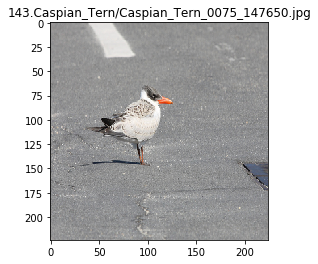

In [24]:
ii = 3
plt.imshow(X_train[ii])
plt.title(df_train.img.iloc[ii])
plt.show()

## CNN Machine Learning Model

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), 
                 activation = 'relu', 
                 input_shape = X_train.shape[1:]))
model.add(MaxPool2D(pool_size = (3,3)))
model.add(Dropout(rate = 0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (3,3)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
model.fit(X_train, y_train, batch_size = 64, epochs= 2, verbose = 1)




Epoch 1/2





13714/13714 [==============================] - 616s 45ms/step - loss: 0.6083 - acc: 0.6854
Epoch 2/2
13714/13714 [==============================] - 608s 44ms/step - loss: 0.5035 - acc: 0.7641


## Predictions and Model Performance


In [28]:
y_train_preds = model.predict_proba(X_train,verbose = 1)
y_valid_preds = model.predict_proba(X_valid,verbose = 1)

3536/3536 [==============================] - 46s 13ms/step


In [0]:
df_valid['pred'] = y_valid_preds

In [30]:
df_valid.loc[(df_valid.OUTPUT_LABEL == 1) ].groupby('bird_class').pred.mean().sort_values(ascending = False)

bird_class
180.Wilson_Warbler                 0.855903
161.Blue_winged_Warbler            0.828371
177.Prothonotary_Warbler           0.798347
167.Hooded_Warbler                 0.790798
182.Yellow_Warbler                 0.784918
168.Kentucky_Warbler               0.781500
162.Canada_Warbler                 0.771037
170.Mourning_Warbler               0.726069
169.Magnolia_Warbler               0.706412
176.Prairie_Warbler                0.701848
175.Pine_Warbler                   0.680212
200.Common_Yellowthroat            0.673630
172.Nashville_Warbler              0.661670
020.Yellow_breasted_Chat           0.608093
163.Cape_May_Warbler               0.600178
173.Orange_crowned_Warbler         0.560706
181.Worm_eating_Warbler            0.538299
179.Tennessee_Warbler              0.506044
178.Swainson_Warbler               0.473122
164.Cerulean_Warbler               0.446293
174.Palm_Warbler                   0.439188
166.Golden_winged_Warbler          0.415645
160.Black_throated_Bl

In [0]:
from sklearn.metrics import roc_auc_score, accuracy_score, \
                            precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print('pred pos:%.3f'%(sum(y_pred > thresh)/len(y_actual)))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [32]:
thresh = 0.5
print('train')
print_report(y_train, y_train_preds[:,0], thresh);
print('valid')
print_report(y_valid, y_valid_preds[:,0], thresh);

train
AUC:0.878
accuracy:0.777
recall:0.662
precision:0.859
specificity:0.891
prevalence:0.500
pred pos:0.386
 
valid
AUC:0.841
accuracy:0.839
recall:0.594
precision:0.471
specificity:0.883
prevalence:0.150
pred pos:0.189
 


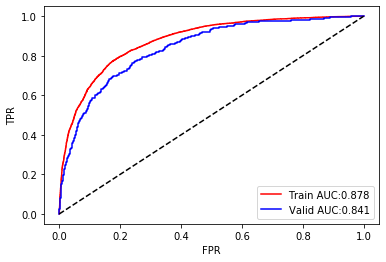

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train, tpr_train, t_train = roc_curve(y_train, y_train_preds[:,0])
auc_train = roc_auc_score(y_train, y_train_preds[:,0])
fpr_valid, tpr_valid, t_valid = roc_curve(y_valid, y_valid_preds[:,0])
auc_valid = roc_auc_score(y_valid, y_valid_preds[:,0])
plt.plot(fpr_train, tpr_train, 'r-', label = 'Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [36]:
!wget https://cangeo-media-library.s3.amazonaws.com/s3fs-public/styles/web_article_slider_image/public/images/web_articles/article_images/5253/8g7d5475-canada.jpg

--2020-03-15 00:01:53--  https://cangeo-media-library.s3.amazonaws.com/s3fs-public/styles/web_article_slider_image/public/images/web_articles/article_images/5253/8g7d5475-canada.jpg
Resolving cangeo-media-library.s3.amazonaws.com (cangeo-media-library.s3.amazonaws.com)... 52.218.228.99
Connecting to cangeo-media-library.s3.amazonaws.com (cangeo-media-library.s3.amazonaws.com)|52.218.228.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63630 (62K) [image/jpeg]
Saving to: ‘8g7d5475-canada.jpg’

8g7d5475-canada.jpg 100%[===================>]  62.14K   366KB/s    in 0.2s    

2020-03-15 00:01:54 (366 KB/s) - ‘8g7d5475-canada.jpg’ saved [63630/63630]



8g7d5475-canada.jpg
1/1 [==============================] - 0s 19ms/step
prob it is warbler:0.886


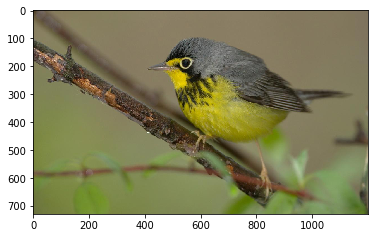

In [37]:
file = '8g7d5475-canada.jpg'
print(file)
x = load_img(file, target_size=(IMG_SIZE, IMG_SIZE),color_mode='rgb')
x= img_to_array(x)/255
x=x.reshape(1,IMG_SIZE,IMG_SIZE, 3)
print('prob it is warbler:%.3f'%model.predict_proba(x,verbose = 1)[0][0])
plt.imshow(load_img(file))
plt.show()